In [24]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

%matplotlib inline

import timeit
#start_time = timeit.default_timer()
# code you want to evaluate
#elapsed = timeit.default_timer() - start_time
print ("libraries loaded")

libraries loaded


In [2]:
#set FIXED variables
HOMEPATH = "/home/ubuntu/fastai/"
#TRAINPATH = HOMEPATH + "dogscats/train/"
#VALIDPATH = HOMEPATH + "dogscats/valid/"


In [3]:
os.chdir(HOMEPATH)
print (os.getcwd())
import utils; reload(utils)
from utils import plots

/home/ubuntu/fastai


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
Using TensorFlow backend.


In [4]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [5]:
#https://keras.io/utils/#get_file
#cached files stored in ~/.keras/
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
print ("fpath:", type(fpath), len(fpath))
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]
print ("classes:", type(classes), len(classes))

fpath: <type 'str'> 52
classes: <type 'list'> 1000


In [6]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

In [7]:
#VGG convolutional block definition
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
print ("method loaded.")

method loaded.


In [8]:
#VGG fully connected ('dense') block
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
print ("method loaded")

method loaded


In [9]:
#subtract vgg_mean for each RGB channel to make mean = 0.
#swap between RGB & BGR
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [10]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [11]:
model = VGG_16()


This previously resulted in error traced to out of memory.  
shutdown jupyter notebook  
start a session with   
sudo watch nvidia-smi  
above this next block memory usage will be minimal.  
GPU memory usage jumped to 10872MiB with next block

In [12]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)
print ("model loaded")

In [16]:
batch_size = 4
path = HOMEPATH + "dogscats/" #nb: preference for this variable name as CAPS.

In [17]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [18]:
print (os.getcwd())
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)
#reminder: needs %matplotlib inline set to be visible

/home/ubuntu/fastai
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


plotting
done


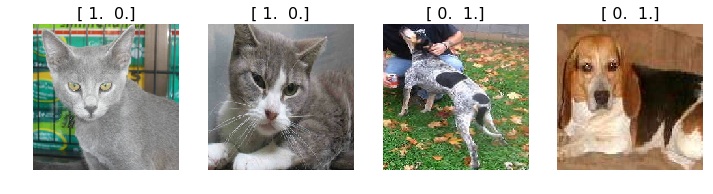

In [25]:
print ("plotting")
plots(imgs, titles=labels)
print ("done")

In [22]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [23]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  2.7524e-06   8.2226e-07   2.6887e-06   1.5142e-06   1.7282e-06]

Predictions prob/class: 
  0.6851/Weimaraner
  0.4659/Egyptian_cat
  0.7227/bluetick
  0.2591/mask
